In [9]:
import tensorflow as tf

2021-12-11 17:48:39.683981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-11 17:48:39.684027: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from math import ceil

In [4]:
tf.__version__

'2.7.0'

In [2]:
from chessutils import find_coeffs
from boardgen import moirebackground

# Datagenerator

In [3]:
PATH_TO_IMG = 'img'

In [4]:
CELL = 45
NUMCELL = 8
BOARDSIZE = CELL*NUMCELL
IMGSIZE = 480
MAXSHEAR = 0.15
MINSCALE = 0.5

In [5]:
figimgs = [f for f in os.listdir(PATH_TO_IMG) if f.split('_')[0]=='Chess']
figuresimgs = dict()
for f in figimgs:
    fn = f.split('_')[1].split('4')[0]
    img = cv2.imread(os.path.join(PATH_TO_IMG, f))
    figuresimgs[fn] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

figs = ['p', 'b', 'n', 'r', 'q', 'k']
colors = ['d', 'l']

In [6]:
NC = 5

In [7]:
def boardmaskgen():
    blank_mask = 255*np.ones((BOARDSIZE,BOARDSIZE), np.uint8)
    blank_image = np.zeros((BOARDSIZE,BOARDSIZE), np.uint8)
    for i in range(NUMCELL*NUMCELL):
        xp = i % NUMCELL
        yp = i // NUMCELL
        if (xp != 0) and (yp != 0):
            blank_mask[yp*CELL-NC:yp*CELL+NC,xp*CELL-NC:xp*CELL+NC] = 0

        empty = np.random.randint(4)
        fgnm = 'x'
        fgcl = 'x'
        figix = 0
        colix = 0
        if (empty == 0):
            figix = np.random.randint(len(figs)) + 1
            fgnm = figs[figix-1]
            colix = np.random.randint(2) + 1
            fgcl = colors[colix-1]

        fldcol = 'l' if (xp+yp) % 2 == 0 else 'd'
        fkey = f'{fgnm}{fgcl}{fldcol}'
        blank_image[yp*CELL:(yp+1)*CELL,xp*CELL:(xp+1)*CELL] = figuresimgs[fkey]

    img = Image.fromarray(blank_image, 'L')
    msk = Image.fromarray(blank_mask, 'L')
    distortrnd = np.random.rand(13)

    m = (2 * distortrnd[:8] - 1) * MAXSHEAR * BOARDSIZE

    x1, y1 = m[0:2]
    x2, y2 = BOARDSIZE+m[2], m[3]
    x3, y3 = BOARDSIZE+m[4], BOARDSIZE+m[5]
    x4, y4 = m[6], BOARDSIZE+m[7]

    xmin = min(x1, x4)
    if (xmin < 0):
        x1 -= xmin
        x2 -= xmin
        x3 -= xmin
        x4 -= xmin

    ymin = min(y1, y2)
    if (ymin < 0):
        y1 -= ymin
        y2 -= ymin
        y3 -= ymin
        y4 -= ymin

    greyscale = int((0.5 + distortrnd[8]*0.5) * 255)

    new_width = int(ceil(max(x2,x3,BOARDSIZE)))
    new_height = int(ceil(max(y3,y4,BOARDSIZE)))
    
    coeffs = find_coeffs(
        [(x1, y1), (x2, y2), (x3, y3), (x4, y4)],
        [(0, 0), (BOARDSIZE, 0), (BOARDSIZE, BOARDSIZE), (0, BOARDSIZE)])
    
    img = img.transform((new_width, new_height), Image.PERSPECTIVE, coeffs, Image.BICUBIC, fillcolor = greyscale)
    msk = msk.transform((new_width, new_height), Image.PERSPECTIVE, coeffs, Image.NEAREST, fillcolor = 'white')

    offsets = distortrnd[9:11]
    scalex, scaley = MINSCALE + (1 - MINSCALE) * distortrnd[11:13]
    
    width, height = img.size
    scaled_wid, scaled_hei = int(round(width * scalex)), int(round(height * scaley))
    img = img.resize((scaled_wid, scaled_hei))
    msk = msk.resize((scaled_wid, scaled_hei), Image.NEAREST)
    
    width, height = img.size

    xoff = (IMGSIZE - width) * offsets[0]
    yoff = (IMGSIZE - height) * offsets[1]

    offset = (int(round(xoff)), int(round(yoff)))

    background = moirebackground(np.random.rand(8), IMGSIZE)

    empty = Image.new('L', (IMGSIZE, IMGSIZE), greyscale)
    empty.paste(img, offset)

    result = (background * np.asarray(empty)).astype(np.float32)

    background_msk = Image.new('L', (IMGSIZE, IMGSIZE), 'white')
    background_msk.paste(msk, offset)
    
    brd_out = np.expand_dims(result / 255, axis=-1)
    msk_out = np.expand_dims(np.asarray(background_msk) / 255, axis=-1)
    
    yield brd_out, msk_out

In [10]:
dataset = tf.data.Dataset.from_generator(boardmaskgen,
                                         output_signature=
                                         (
                                          tf.TensorSpec(shape=(IMGSIZE,IMGSIZE,1), dtype=tf.float32),
                                          tf.TensorSpec(shape=(IMGSIZE,IMGSIZE,1), dtype=tf.float32)
                                         ))

2021-12-11 17:50:49.965564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-11 17:50:49.965616: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-11 17:50:49.965648: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ilia-ThinkPad-S5-S540): /proc/driver/nvidia/version does not exist
2021-12-11 17:50:49.970182: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
for f in dataset.take(1):
    print(f[0].shape, f[1].shape)

(480, 480, 1) (480, 480, 1)


In [12]:
for f in dataset.take(1):
    print(np.unique(f[1]))

[0. 1.]


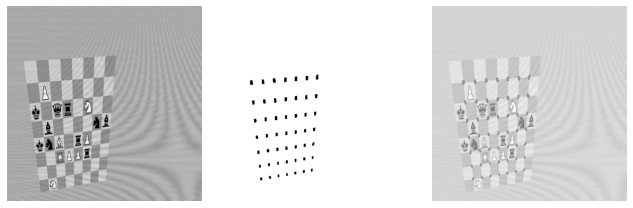

In [13]:
for f in dataset.repeat(20).take(1):
    fig, axxes = plt.subplots(ncols=3, nrows=1, figsize=(9,3), sharex=True, sharey=True)
    axxes[0].imshow(np.squeeze(f[0]), cmap='gray')
    axxes[1].imshow(np.squeeze(f[1]), cmap='gray')
    axxes[2].imshow(np.squeeze(f[1]), cmap='gray', alpha=0.5)
    axxes[2].imshow(np.squeeze(f[0]), cmap='gray', alpha=0.5)
    axxes[0].axis('off')
    axxes[1].axis('off')
    axxes[2].axis('off')
    fig.tight_layout()
    plt.show()

In [17]:
trainset = dataset.repeat().batch(8)
valset = dataset.repeat(50).batch(1)

## UNET

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten, Conv2DTranspose, Concatenate

In [19]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, name, kernel_size=3):
    '''
    Adds 2 convolutional layers with the parameters passed to it

    Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

    Returns:
    tensor of output features
    '''
    # first layer
    x = input_tensor
    for i in range(2):
        x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
                kernel_initializer = 'he_normal', padding = 'same', activation='relu', name=f'{name}_{i}')(x)

    return x


def encoder_block(inputs, name, n_filters=64, pool_size=(2,2), dropout=0.3):
    '''
    Adds two convolutional blocks and then perform down sampling on output of convolutions.

    Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

    Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
    '''

    f = conv2d_block(inputs, n_filters=n_filters, name=f'{name}_conv')
    p = MaxPooling2D(pool_size=(2,2), name=f'{name}_pool')(f)
    p = Dropout(0.3, name=f'{name}_drop')(p)

    return f, p


def encoder(inputs):
    '''
    This function defines the encoder or downsampling path.

    Args:
    inputs (tensor) -- batch of input images

    Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
    '''
    f1, p1 = encoder_block(inputs, name='enc1', n_filters=32, pool_size=(2,2), dropout=0.3)
    f2, p2 = encoder_block(p1, name='enc2', n_filters=64, pool_size=(2,2), dropout=0.3)

    return p2, (f1, f2)

In [20]:
def bottleneck(inputs):
    '''
    This function defines the bottleneck convolutions to extract more features before the upsampling layers.
    '''

    bottle_neck = conv2d_block(inputs, n_filters=128, name='bneck')

    return bottle_neck

In [21]:
# Decoder Utilities

def decoder_block(inputs, conv_output, name, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
    '''
    defines the one decoder block of the UNet

    Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

    Returns:
    c (tensor) -- output features of the decoder block
    '''
    u = Conv2DTranspose(
      n_filters,
      kernel_size, 
      strides=strides,
      padding='same', name=f'{name}_trans')(inputs)
    c = Concatenate(name=f'{name}_conc')([u, conv_output])
    c = Dropout(dropout, name=f'{name}_drop')(c)
    c = conv2d_block(c, n_filters, name=f'{name}_conv', kernel_size=3)

    return c


def decoder(inputs, convs):
    '''
    Defines the decoder of the UNet chaining together 4 decoder blocks. 

    Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks

    Returns:
    outputs (tensor) -- the pixel wise label map of the image
    '''

    f1, f2 = convs

    c8 = decoder_block(inputs, f2, name='dec2', n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    c9 = decoder_block(c8, f1, name='dec3', n_filters=32, kernel_size=(3,3), strides=(2,2), dropout=0.3)

    outputs = Conv2D(2, (1, 1), activation='softmax', name='finalb')(c9)

    return outputs

In [22]:
def unet():
    '''
    Defines the UNet by connecting the encoder, bottleneck and decoder.
    '''

    inputs = tf.keras.layers.Input(shape=(IMGSIZE,IMGSIZE,1))
    encoder_output, convs = encoder(inputs)
    bottle_neck = bottleneck(encoder_output)
    outputs = decoder(bottle_neck, convs)
    model = Model(inputs=inputs, outputs=outputs, name='unet_board')

    return model

In [23]:
model = unet()
model.summary()

Model: "unet_board"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 1  0           []                               
                                )]                                                                
                                                                                                  
 enc1_conv_0 (Conv2D)           (None, 480, 480, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 enc1_conv_1 (Conv2D)           (None, 480, 480, 32  9248        ['enc1_conv_0[0][0]']            
                                )                                                        

In [28]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# configure the training parameters and train the model

EPOCHS = 3

model_history = model.fit(trainset,
                          steps_per_epoch=200,
                          epochs=EPOCHS,
                          validation_data=valset)

Epoch 1/3
200/200 [==============================] - 285s 1s/step - loss: 0.0091 - accuracy: 0.9961 - val_loss: 0.0073 - val_accuracy: 0.9967
Epoch 2/3
200/200 [==============================] - 283s 1s/step - loss: 0.0087 - accuracy: 0.9962 - val_loss: 0.0083 - val_accuracy: 0.9963
Epoch 3/3
200/200 [==============================] - 284s 1s/step - loss: 0.0083 - accuracy: 0.9964 - val_loss: 0.0081 - val_accuracy: 0.9964


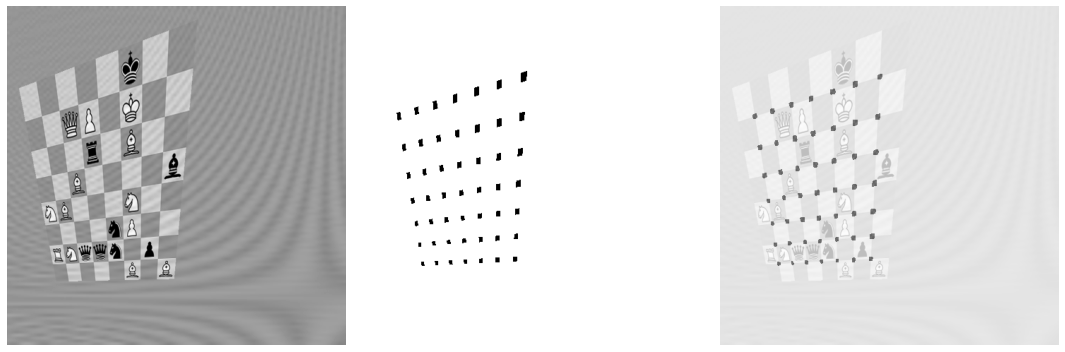

In [31]:
for g in valset.take(1):
    fig, axx = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
    axx[0].imshow(np.squeeze(g[0].numpy()), cmap='gray')
    axx[0].axis('off')
    axx[1].imshow(g[1].numpy()[0,:,:,0], cmap='gray')
    axx[1].axis('off')
    pred = np.squeeze(model.predict(g[0]))
    b = np.argmax(pred[:,:,0:2], axis=-1)
    axx[2].imshow(np.squeeze(g[0].numpy()), cmap='gray', alpha=0.5)
    axx[2].imshow(b, cmap='gray', alpha=0.5)
    axx[2].axis('off')
    fig.tight_layout()
    plt.show()

In [30]:
model.save('models/unet_board_v4.h5')